# Apresentação ✒️

Notebook destinado ao estudo de advanced retrieval for AI (recuperação avançada para IA). Circunscreve-se no contexto da técnica conhecida como Retrieval Argument Generation (RAG), que consiste na recuperação de informação a partir de um local de seu armazenamento, por meio da qual a LLM de uso pode utilizar de insumo para geração de respostas a partir de uma consulta do usuário.

Objetiva-se por meio dela prover um cenário no qual não dependa-se do treinamento prévio do modelo, a fim de oferecer respostas precisas ao cenário de uso e nem a necessidade de realizar um ajuste fino (fine tuning), bastando informar a ele o elemento recuperado por meio da consulta, a partir do qual o torna habilitado a responder às consultas do usuário de forma mais precisa.

Em virtude disso, configura-se numa abordagem relevante para aplicações com IAs generativas, imersas a um contexto de busca semântica e chatbots, que habilita a IA a responder o usuário de forma mais aderente ao contexto de aplicação no qual está inserida.

Nesse sentido, o estudo da recuperação avançada se delimita na compreensão de técnicas que possam auxiliar a eficiência da extração da informação contida no armazenamento. A sua importância se dá, além desse aspecto, no fato de que a sua implementação padrão por meio da similaridade vetorial nem sempre ser o suficiente para prover retornos relevantes à consulta do usuário, por mais que seja semelhante da perspectiva vetorial.

Desse modo, no presente notebook, estudará a implementação da técnica conhecida como cross-encoder re-rank, com a combinação da abordagem conhecida como expansive query (consulta expandida).

O notebook está dividido da seguinte forma :

- importação das bibliotecas

- definição da variável de ambiente e modelo de LLM utilizado

- carregamento do arquivo utilizado

- divisão do texto em duas etapas

- criação do banco de dados vetorial

- adição da divisão do texto no banco de dados vetorial

- realização da primeira consulta sem nenhuma técnia associada - baseline

- visualização da eficiência da primeira consulta

- realização da consulta com a técnica de expansive query

- visualização da sua eficiência

- combinação com o cross-encoder (2° etapa de seleção)

- reordenação dos documentos mais relevantes

- implementação da técnica conhecida como RAG a partir dos documentos mais relevantes.



## Biblioteca 📚

In [2]:
!pip install langchain langchain__community langchain_google_genai chromadb -q

!pip install google-generativeai sentence-transformers -q

!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:

!pip install pypdf -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 5.0 MB/s eta 0:00:00


In [76]:
import os
import umap.umap_ as umap
import numpy as np
import chromadb
import google.generativeai as genai
import matplotlib.pyplot as plt

from langchain.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain import PromptTemplate
from langchain.chains import LLMChain

from pypdf import PdfReader

from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

from sentence_transformers import CrossEncoder

from tqdm import tqdm

## Definindo a variável de ambiente e LLM 🤖

In [9]:
os.environ["GOOGLE_API_KEY"] = ""

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [10]:

llm = ChatGoogleGenerativeAI(
    model = "gemini-1.5-pro-latest",
    temperature=0.2
)

## Carregando o arquivo utilizado 💾

In [11]:
file_path = "/content/2405.06643v1.pdf"

reader = PdfReader(file_path)

# Extraindo o texto do objeto PdfReader, que apenas havia
# lido e armazenado o texto.

pdf_text = [p.extract_text() for p in reader.pages]

# Extraindo apenas o texto e desconsiderando porções em branco.

pdf_text = [text for text in pdf_text if text]

In [12]:
# Visualizando o texto carregado.

pdf_text[0]

'Levels of AI Agents: from Rules to Large Language Models  Yu Huang Roboraction.AI  Abstract:   AI agents are defined as artificial entities to perceive the environment, make decisions and take actions. Inspired by the 6 levels of autonomous driving by SAE (Society of Automotive Engineers), the AI agents are also categorized based on utilities and strongness, as the following levels: L0—no AI, with tools (with perception) plus actions; L1—use rule-based AI; L2—let rule-based AI replaced by IL/RL-based AI, with additional reasoning & decision making; L3—apply LLM-based AI instead of IL/RL-based AI, additionally setting up memory & reflection; L4—based on L3, facilitating autonomous learning & generalization; L5—based on L4, appending personality (emotion + character) and collaborative behavior (multi-agents).  1 Introduction  Any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. Agents can be categorized into five types: Simple Reflex age

In [13]:
print(f'Quantidade de páginas presentes no arquivo : {len(pdf_text)}')

Quantidade de páginas presentes no arquivo : 8


## Dividindo o texto

Antes do texto passar pelo processo de embedding e ser enviado a um banco de dados vetorial (vector db), faz-se necessário que o esse seja dividido em menores partes, buscando a otimização durante o processo de recuperação da informação armazenada com base na consulta do usuário.

Desse modo, essa etapa perpassa duas etapas de divisão, a primeira realizada por meio de um divisor por caractere recursivo, que irá realizar a segmentação contabilizando o arquivo como um todo, e a segunda, que irá realizar uma divisão por tokens, como forma de criar porções semânticamente relevantes.

Para saber mais : https://medium.com/@hadiazouni/text-splitting-chunking-for-rag-applications-7ccbb6dcc9f9

In [121]:
# Divisão por caractere

recursive_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 2000,
    chunk_overlap = 150,
    length_function = len,
    separators=['\n\n', '\n', '.', ' ', '']
)

text_splitted_rc = recursive_splitter.split_text('\n\n'.join(pdf_text))


In [122]:
print(f'Quantidade de partes geradas após a primeira divisão : {len(text_splitted_rc)}')

Quantidade de partes geradas após a primeira divisão : 16


In [123]:
# Visualizando o texto dividido.

text_splitted_rc[:1]

['Levels of AI Agents: from Rules to Large Language Models  Yu Huang Roboraction.AI  Abstract:   AI agents are defined as artificial entities to perceive the environment, make decisions and take actions. Inspired by the 6 levels of autonomous driving by SAE (Society of Automotive Engineers), the AI agents are also categorized based on utilities and strongness, as the following levels: L0—no AI, with tools (with perception) plus actions; L1—use rule-based AI; L2—let rule-based AI replaced by IL/RL-based AI, with additional reasoning & decision making; L3—apply LLM-based AI instead of IL/RL-based AI, additionally setting up memory & reflection; L4—based on L3, facilitating autonomous learning & generalization; L5—based on L4, appending personality (emotion + character) and collaborative behavior (multi-agents).  1 Introduction  Any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. Agents can be categorized into five types: Simple Reflex ag

In [124]:
# Segunda divisão por tokens.

token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=256,
    chunk_overlap=0
)

In [125]:
token_split_text = []

for text in text_splitted_rc:

  token_split_text += token_splitter.split_text(text)

In [126]:
# Visualizando o texto após a segunda divisão.

token_split_text[:1]

['levels of ai agents : from rules to large language models yu huang roboraction. ai abstract : ai agents are defined as artificial entities to perceive the environment, make decisions and take actions. inspired by the 6 levels of autonomous driving by sae ( society of automotive engineers ), the ai agents are also categorized based on utilities and strongness, as the following levels : l0 — no ai, with tools ( with perception ) plus actions ; l1 — use rule - based ai ; l2 — let rule - based ai replaced by il / rl - based ai, with additional reasoning & decision making ; l3 — apply llm - based ai instead of il / rl - based ai, additionally setting up memory & reflection ; l4 — based on l3, facilitating autonomous learning & generalization ; l5 — based on l4, appending personality ( emotion + character ) and collaborative behavior ( multi - agents ). 1 introduction any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. agents can be catego

In [127]:
print(f'Quantidade de partes geradas após a segunda divisão : {len(token_split_text)}')

Quantidade de partes geradas após a segunda divisão : 32


Antes da divisão do arquivo havia 8 páginas, que se estenderam para 29 porções, sendo seguidos por 33 porções após a divisão por tokens.

## Instanciando o modelo de embedding

O modelo de embedding se refere ao algoritmo que transforma elementos de linguagem natural em uma representação vetorial. A sua importância reside no fato de que apenas desse modo consegue-se armazenar dados em um espaço vetorial, como um vector db.

In [30]:
# Dados transformados de linguagem natural para uma representação vetorial,
# por meio de embedding habilita que sejam que esses banco de dados vetorial
# para serem consultados posteriormente.

embedding_function = SentenceTransformerEmbeddingFunction()

## Criando o banco de dados vetorial

In [32]:
# Criando o banco de dados vetorial. O banco de dados escolhido
# é o Chroma, um framework open source que habilita a criação
# desses bancos para uso.

# Criando o objeto chroma_client, que me permitirá interagir com o ChromaDB.

chroma_client = chromadb.Client()

# Criando o banco de dados vetorial. Para isso, define-se seu nome e o modelo
# de embedding de uso.

chroma_db = chroma_client.create_collection(name = "levels_of_ai_agents", embedding_function = embedding_function)

In [33]:
# Gerando uma lista de identificação para cada porção
# presente no meu banco de dados vetorial.

ids = [str(i) for i in range(len(token_split_text))]


In [34]:
# Adicionando os documentos ao banco de dados vetorial
# junto de cada identificação.

chroma_db.add(ids=ids, documents=token_split_text)

In [35]:
# Verificando a quantidade de itens no banco de dados vetorial.

chroma_db.count()

33

## Realizando a consulta da informação

Nessa etapa irei demonstrar uma abordagem de consulta do tipo padrão, sem utilizar-se de técnicas que visam a eficiência da recuperação e outra que utiliza-se dessas, que será uma combinação de expansive query com cross-encoder re-rank.

### Implementando a busca padrão

In [36]:
"""
Para visualizar o impacto que as técnicas de recuperação avançada
representam no instante da consulta do usuário, irei criar um gráfico
de dispersão em duas dimensões. Nele, estará dispostos os vetores
(representados por círculos) que representam os dados armazenados, bem
como o elemento de consulta, representado por x, e os vetores que seriam
mais relevantes a essa, representados por um contorno circular verde nos vetores.
"""

# Para criar esse gráfico, antes precisarei realizar a transformação
# dimensional do vector db.

# Extraindo os embeddings do vector db :

embeddings = chroma_db.get(include=['embeddings'])["embeddings"]

# Ajustando o modelo de transformação dimensional aos embeddings presentes :

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [37]:
# Criando a função que irá realizar a representação gráfica do vector db

def visualize_vector_db(embeddings, umap_transform):

  # Criando um array vazio para armazenar os embeddings representados.

  umap_embeddings = np.empty((len(embeddings), 2))

  # Realizando a transformação dimensional dos embeddings

  for i, embedding in enumerate(tqdm(embeddings)):

    umap_embeddings[i] = umap_transform.transform([embedding])

  return umap_embeddings

In [38]:
vector_db_graph = visualize_vector_db(embeddings, umap_transform)

100%|██████████| 33/33 [00:54<00:00,  1.65s/it]


(9.634798526763916, 14.345866680145264, 1.8349522709846497, 7.94660314321518)

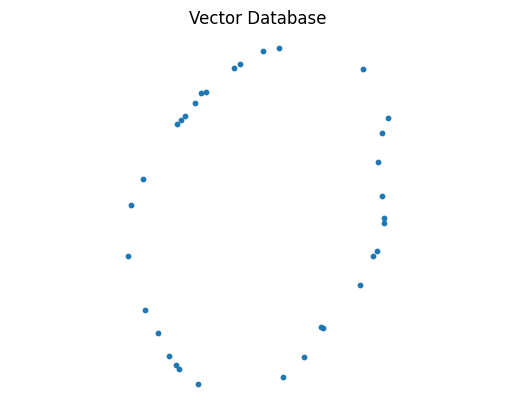

In [42]:
# Para visualizar graficamente :

plt.figure()
plt.scatter(vector_db_graph[:, 0], vector_db_graph[:, 1], s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Vector Database')
plt.axis('off')



In [48]:
# Realizando a consulta e verificando a sua eficiência
# a partir da visualização do gráfico do vector db.

query = "What they are Agents AI ?"

retrieve = chroma_db.query(query_texts=[query], n_results=5, include=["documents", "embeddings"])

retrieved_documents = retrieve["documents"][0]

In [49]:
# Visualizando a recuperação dos documentos presentes no vector db,
# com base na consulta realizada.

retrieved_documents

['levels of ai agents : from rules to large language models yu huang roboraction. ai abstract : ai agents are defined as artificial entities to perceive the environment, make decisions and take actions. inspired by the 6 levels of autonomous driving by sae ( society of automotive engineers ), the ai agents are also categorized based on utilities and strongness, as the following levels : l0 — no ai, with tools ( with perception ) plus actions ; l1 — use rule - based ai ; l2 — let rule - based ai replaced by il / rl - based ai, with additional reasoning & decision making ; l3 — apply llm - based ai instead of il / rl - based ai, additionally setting up memory & reflection ; l4 — based on l3, facilitating autonomous learning & generalization ; l5 — based on l4, appending personality ( emotion + character ) and collaborative behavior ( multi - agents ). 1 introduction any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. agents can be catego

In [52]:
# Visualizando a eficiência da recuperação :

query_embedding = embedding_function(query)[0]

retrieved_embedding = retrieve["embeddings"][0]

In [53]:
visualize_query_embedding = visualize_vector_db([query_embedding], umap_transform)
visualize_retrieved_embedding = visualize_vector_db(retrieved_embedding, umap_transform)

100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


(9.589250755310058, 14.348035621643067, 1.8349522709846497, 7.94660314321518)

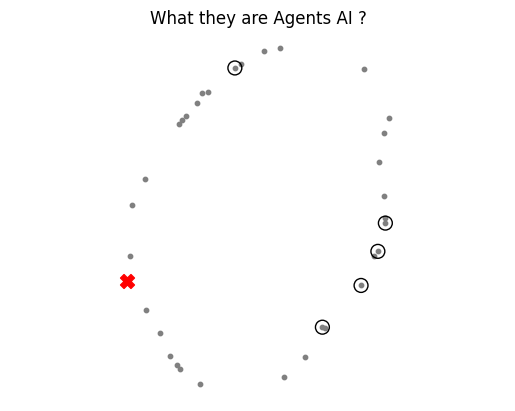

In [54]:
# Realizando a visualização gráfica :

plt.figure()
plt.scatter(vector_db_graph[:, 0], vector_db_graph[:, 1], s = 10, color = 'gray')

plt.scatter(visualize_query_embedding[:, 0], visualize_query_embedding[:, 1],
            s = 100, marker = 'X', color = 'r')

plt.scatter(visualize_retrieved_embedding[:, 0], visualize_retrieved_embedding[:, 1],
            s = 100, facecolors = 'none', edgecolors = 'black')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

O gráfico acima busca informar como ocorre a recuperação da informação no banco de dados vetorial, utilizando-se apenas da consulta e da sua similaridade vetorial com os elementos nesse presentes.

Nota-se que os dados escolhidos distam dos vetores que possuiriam maior relevância para responder a query informada.

Na marcação do X, em vermelho, está os vetores selecionados, enquanto que os mais relevantes são circulados por um contorno em preto.

### Implementando a busca com expansive query mais cross-encoder re-rank

Essa implementação é seguida por duas principais etapas. A primeira configura-se na primeira recuperação dos dados, com base na consulta informada, enquanto que a segunda se define por ser uma etapa da seleção do conteúdo mais relevante dos documentos previamente selecionados.

No presente cenário, estou combinando essa abordagem com a técnica conhecida como query expansive (expansão da consulta) a partir da qual busco fornecer mais contexto para a pesquisa, buscando promover uma delimitação maior do campo de busca, que somente a query poderia deixar a desejar.

Para a realização da recuperação da informação utiliza-se por padrão o ângulo encontrado pelo cosseno, para avaliar a similaridade vetorial entre o elemento de consulta e os dados presentes no banco de dados vetorial. Não obstante, na segunda etapa de seleção, desempenhada pelo cross-encoder essa técnica também é utilizada, mas em conjunto de consulta e elementos a serem recuperados, realizando uma pontuação para cada qual. Aqueles que apresentam melhores pontuações são tidos como mais relevantes, enquanto os que apresentam o oposto são tidos como menos relevantes.

### Primeira etapa : extração da informação com expasive query

In [104]:
def hypothetical_answer(query, model = llm):

  prompt_template = PromptTemplate(
      input_variables = ["query"],
      template = (
        """
        Your are helpful specialist in artificial inteligence developer.
        Provide an detail example answer to the given question, that might be found
        in a document that talks about AI Agents.

        Question : {query}

        Helpful Answer :

        """
        )
      )

  chain = LLMChain(llm = model, prompt = prompt_template)

  response = chain.run(query = query)

  return response



In [105]:
original_query = "What they are Agents AI ?"
hypothetical_answer_output = hypothetical_answer(original_query)

In [106]:
# Visualizando as perguntas geradas pelo modelo.

hypothetical_answer_output

"## Helpful Answer: What are AI Agents?\n\nImagine a digital assistant that not only follows your instructions but can also learn from its experiences, adapt to changing environments, and make decisions to achieve specific goals. That's the essence of an **AI agent**. \n\nIn simpler terms, an **AI agent** is a **software program** or **system** that:\n\n1. **Perceives its environment** through **sensors**, which could be anything from cameras and microphones to data streams and databases.\n2. **Processes this information** using its **artificial intelligence**, which could be a set of rules, a machine learning model, or a complex neural network.\n3. **Takes actions** to achieve its **goals**, using **actuators** that interact with its environment. These actions could be anything from sending an email or controlling a robot arm to making a trade on the stock market or recommending a product.\n\n**Here's an analogy:** Think of a self-driving car. \n\n* **Sensors:** Cameras, radar, lidar,

In [107]:
# Realizando a primeira etapa da busca, com expansive query :

joint_query = f'{original_query}\n\n{hypothetical_answer_output}'

joint_query

"What they are Agents AI ?\n\n## Helpful Answer: What are AI Agents?\n\nImagine a digital assistant that not only follows your instructions but can also learn from its experiences, adapt to changing environments, and make decisions to achieve specific goals. That's the essence of an **AI agent**. \n\nIn simpler terms, an **AI agent** is a **software program** or **system** that:\n\n1. **Perceives its environment** through **sensors**, which could be anything from cameras and microphones to data streams and databases.\n2. **Processes this information** using its **artificial intelligence**, which could be a set of rules, a machine learning model, or a complex neural network.\n3. **Takes actions** to achieve its **goals**, using **actuators** that interact with its environment. These actions could be anything from sending an email or controlling a robot arm to making a trade on the stock market or recommending a product.\n\n**Here's an analogy:** Think of a self-driving car. \n\n* **Sens

In [108]:
results = chroma_db.query(query_texts=joint_query, n_results=10, include=["documents",
                                                                      "embeddings"])

In [109]:
retrieved_documents = results['documents'][0]

In [110]:
# Visualizando alguns dos documentos extraídos.

retrieved_documents[:2]

['levels of ai agents : from rules to large language models yu huang roboraction. ai abstract : ai agents are defined as artificial entities to perceive the environment, make decisions and take actions. inspired by the 6 levels of autonomous driving by sae ( society of automotive engineers ), the ai agents are also categorized based on utilities and strongness, as the following levels : l0 — no ai, with tools ( with perception ) plus actions ; l1 — use rule - based ai ; l2 — let rule - based ai replaced by il / rl - based ai, with additional reasoning & decision making ; l3 — apply llm - based ai instead of il / rl - based ai, additionally setting up memory & reflection ; l4 — based on l3, facilitating autonomous learning & generalization ; l5 — based on l4, appending personality ( emotion + character ) and collaborative behavior ( multi - agents ). 1 introduction any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. agents can be catego

### Visualizando o ganho que a expansive query oferece no campo de busca.

In [111]:
# Visualiando a melhora no campo de busca com a utilização
# da expansion query :

retrieved_embedding = results['embeddings'][0]
original_query_embedding = embedding_function(original_query)[0]
argument_query_embedding = embedding_function(hypothetical_answer_output)[0]

visualize_original_query_embedding = visualize_vector_db([original_query_embedding], umap_transform)
visualize_argument_query_embedding = visualize_vector_db([argument_query_embedding], umap_transform)
visualize_retrieved_embedding = visualize_vector_db(retrieved_embedding, umap_transform)

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


(9.589250755310058, 14.348035621643067, 1.8349522709846497, 7.94660314321518)

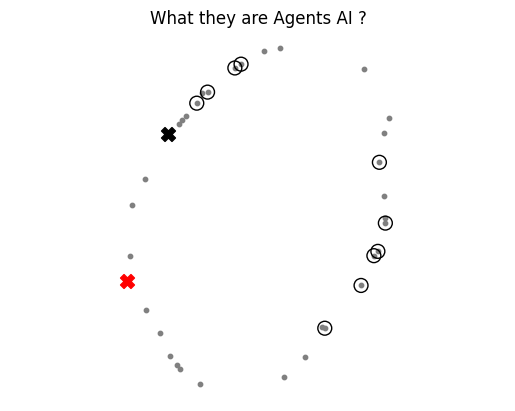

In [112]:
plt.figure()

plt.scatter(vector_db_graph[:, 0], vector_db_graph[:, 1], s = 10, color = 'gray')

plt.scatter(visualize_original_query_embedding[:, 0], visualize_original_query_embedding[:, 1],
            s = 100, marker = 'X', color = 'red')

plt.scatter(visualize_argument_query_embedding[:, 0], visualize_argument_query_embedding[:, 1],
            s = 100, marker = 'X', color = 'black')

plt.scatter(visualize_retrieved_embedding[:, 0], visualize_retrieved_embedding[:, 1],
            s = 100, facecolors = 'none', edgecolors = 'black')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Como pode ser observado graficamente. A consulta original sem a combinação da query promove uma seleção distante dos vetores mais relevantes, enquanto que a combinação (X na coloração preta), apresenta uma menor distãncia entre alguns desses.

### Segunda etapa : extração da informação com cross-encoder

In [113]:
# Instanciando o modelo de cross-encoder para a realização
# da segunda etapa de seleção dos documentos mais relevantes
# à consulta do usuário.

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [114]:
# Formando o par consulta e documentos.

pairs = [[query, doc] for doc in retrieved_documents]

# Obtendo a pontuação dos documentos, com base na consulta.
# Aqueles que apresentam a melhor pontuação são aqueles que
# são tidos como mais relevantes em responder a consulta.

scores = cross_encoder.predict(pairs)

In [115]:
# Etapa 4: Ordenando os documentos com base nos scores obtidos

documents_with_scores = list(zip(retrieved_documents, scores))

In [116]:
# Visualizando os documentos extraídos na primeira etapa
# com a sua respectiva pontuação.

documents_with_scores

[('levels of ai agents : from rules to large language models yu huang roboraction. ai abstract : ai agents are defined as artificial entities to perceive the environment, make decisions and take actions. inspired by the 6 levels of autonomous driving by sae ( society of automotive engineers ), the ai agents are also categorized based on utilities and strongness, as the following levels : l0 — no ai, with tools ( with perception ) plus actions ; l1 — use rule - based ai ; l2 — let rule - based ai replaced by il / rl - based ai, with additional reasoning & decision making ; l3 — apply llm - based ai instead of il / rl - based ai, additionally setting up memory & reflection ; l4 — based on l3, facilitating autonomous learning & generalization ; l5 — based on l4, appending personality ( emotion + character ) and collaborative behavior ( multi - agents ). 1 introduction any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. agents can be categ

In [117]:
# Reordenando os documentos, com base em sua pontuação.
# Aqueles que apresentam maior pontuação são tidos como mais relevantes.

ranked_documents = sorted(documents_with_scores, key=lambda x: x[1], reverse=True)

In [118]:
# Visualizando os documentos reordenados :

ranked_documents

[('levels of ai agents : from rules to large language models yu huang roboraction. ai abstract : ai agents are defined as artificial entities to perceive the environment, make decisions and take actions. inspired by the 6 levels of autonomous driving by sae ( society of automotive engineers ), the ai agents are also categorized based on utilities and strongness, as the following levels : l0 — no ai, with tools ( with perception ) plus actions ; l1 — use rule - based ai ; l2 — let rule - based ai replaced by il / rl - based ai, with additional reasoning & decision making ; l3 — apply llm - based ai instead of il / rl - based ai, additionally setting up memory & reflection ; l4 — based on l3, facilitating autonomous learning & generalization ; l5 — based on l4, appending personality ( emotion + character ) and collaborative behavior ( multi - agents ). 1 introduction any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. agents can be categ

In [119]:
# Extraindo os 5 documentos mais relevantes, com base na consulta do usuário,
# com base na reordenação anteriormente realizada.

top5_re_ranked_documents = [doc for doc, score in ranked_documents[:5]]

In [120]:
# Visualizando os documentos com maior pontuação.

top5_re_ranked_documents

['levels of ai agents : from rules to large language models yu huang roboraction. ai abstract : ai agents are defined as artificial entities to perceive the environment, make decisions and take actions. inspired by the 6 levels of autonomous driving by sae ( society of automotive engineers ), the ai agents are also categorized based on utilities and strongness, as the following levels : l0 — no ai, with tools ( with perception ) plus actions ; l1 — use rule - based ai ; l2 — let rule - based ai replaced by il / rl - based ai, with additional reasoning & decision making ; l3 — apply llm - based ai instead of il / rl - based ai, additionally setting up memory & reflection ; l4 — based on l3, facilitating autonomous learning & generalization ; l5 — based on l4, appending personality ( emotion + character ) and collaborative behavior ( multi - agents ). 1 introduction any entity, that is able to perceive its environment and execute actions, can be regarded as an agent. agents can be catego

## Realizando a técnica RAG, com os melhores documentos selecionados

In [129]:
def rag(query, retrieved_documents, model = llm):

  information = '\n\n'.join(retrieved_documents)

  prompt_template = PromptTemplate(
      input_variables = ["query", "information"],
      template = ("""
      You are an experienced and efficient generative AI developer.
      You need to respond in a clear and informative way to the user's query
      on the topic of AI agents. You will be presented with the user query
      and the relevant parts of an article that talks about the topic.
      Answer the user's question using only the information presented to you.

      Question : {query}
      Information : {information}

      Helpful Answer :
      """)
  )

  chain = LLMChain(llm = llm, prompt = prompt_template)

  response = chain.run(query = query,
                       information = information)

  return

In [130]:
bot = rag(original_query, top5_re_ranked_documents)

In [131]:
bot

'AI agents are artificial entities designed to perceive their environment, make decisions, and take actions based on their perceptions. They can be as simple as rule-based systems or as complex as large language models (LLMs) that can learn and adapt. \n\nEssentially, they are entities that can understand, predict, and respond based on their training and input data. \n'